In [11]:
import pysm3
import pysm3.units as u
import healpy as hp
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import pickle

NSIDE = 2048
mlmax = 4000


from matplotlib.lines import Line2D
from matplotlib import rcParams
from matplotlib import cm
from matplotlib.colors import to_hex

rcParams['font.size']=20
rcParams['axes.linewidth']=1.5
rcParams['xtick.major.width']=1.5
rcParams['xtick.minor.width']=1
rcParams['ytick.major.width']=1.5
rcParams['ytick.minor.width']=1
rcParams['xtick.major.pad']='8'
rcParams['xtick.direction'] = 'in'
rcParams['xtick.top'] = True
rcParams['ytick.direction'] = 'in'
rcParams['xtick.minor.visible'] = True
rcParams['ytick.minor.visible'] = True
rcParams['ytick.right'] = True
rcParams['text.usetex'] = True
rcParams['font.family'] = 'Helvetica'

# Función para obtener colores discretos de un colormap
def get_discrete_colors(cmap_name, num_colors):
    cmap = cm.get_cmap(cmap_name, num_colors)
    return [to_hex(cmap(i)) for i in range(num_colors)]

%matplotlib inline

In [2]:
# TTYPE1  = 'GAL020  '           / 20% sky coverage      0                 
# TTYPE2  = 'GAL040  '           / 40% sky coverage      1                
# TTYPE3  = 'GAL060  '           / 60% sky coverage      2               
# TTYPE4  = 'GAL070  '           / 70% sky coverage      3              
# TTYPE5  = 'GAL080  '           / 80% sky coverage      4             
# TTYPE6  = 'GAL090  '           / 90% sky coverage      5            
# TTYPE7  = 'GAL097  '           / 97% sky coverage      6           
# TTYPE8  = 'GAL099  '           / 99% sky coverage      7

In [3]:
dict_mask = {0: 'GAL040', 1: 'GAL060', 2: 'GAL070', 3: 'GAL080'}

0.23685056
0.26935104
0.3887465
0.4305749
0.48763943
0.53061193
0.58640265
0.6297545


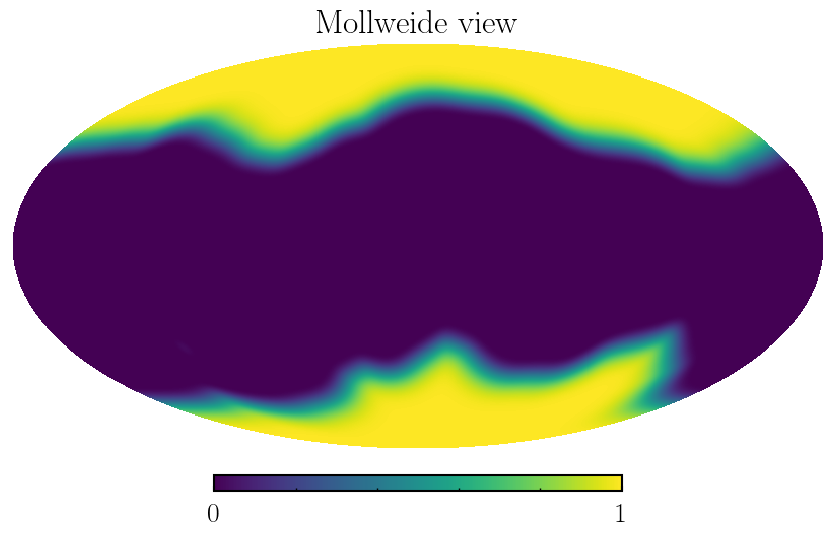

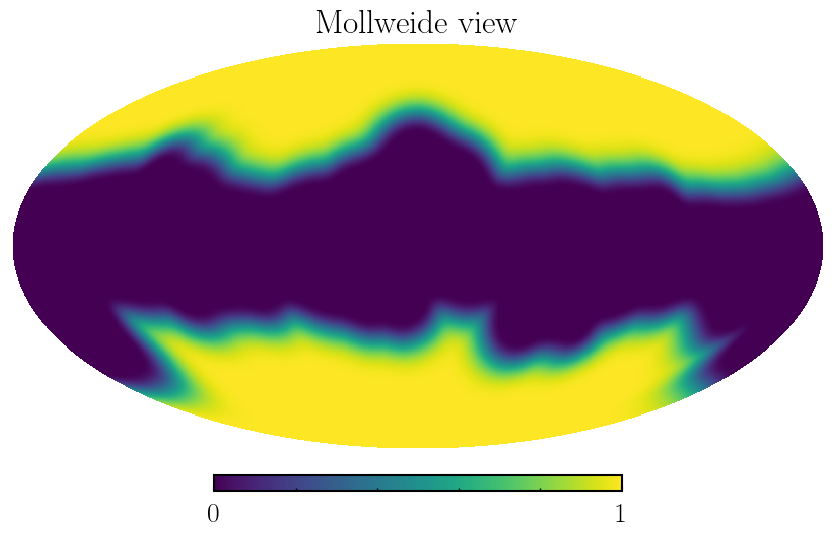

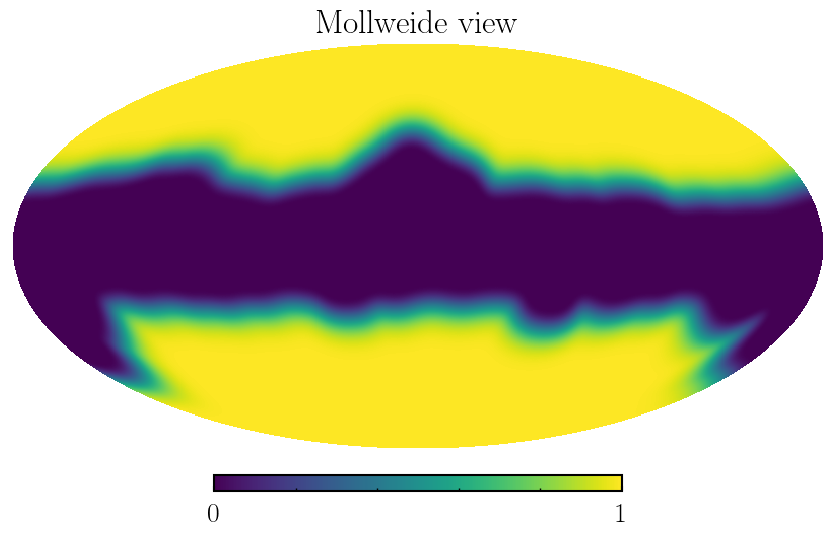

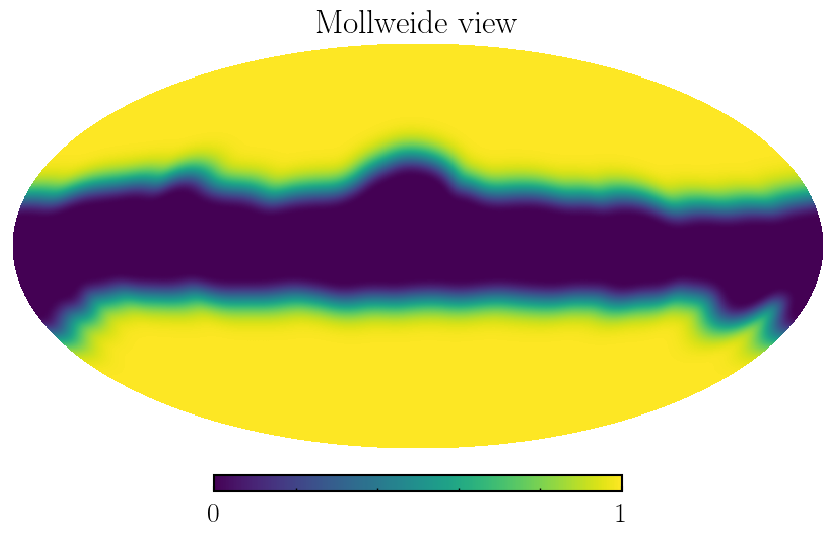

In [4]:
masks = hp.read_map("/rds/project/dirac_vol5/rds-dirac-dp002/ia404/fgs/Planck/HFI_Mask_GalPlane-apo5_2048_R2.00.fits", field=[1,2,3,4])
w2_masks = {}
w_masks = {}
for i in range(4):
    w2_masks[i] = np.mean(masks[i]**2)
    w_masks[i] = np.mean(masks[i])
    print(w2_masks[i])
    print(w_masks[i])
    hp.mollview(masks[i])

Freq: 90.0 PySM: d9
Mask: 0
Mask: 1
Mask: 2
Mask: 3
Freq: 90.0 PySM: d10
Mask: 0
Mask: 1
Mask: 2
Mask: 3
Freq: 150.0 PySM: d9
Mask: 0
Mask: 1
Mask: 2
Mask: 3
Freq: 150.0 PySM: d10
Mask: 0
Mask: 1
Mask: 2
Mask: 3


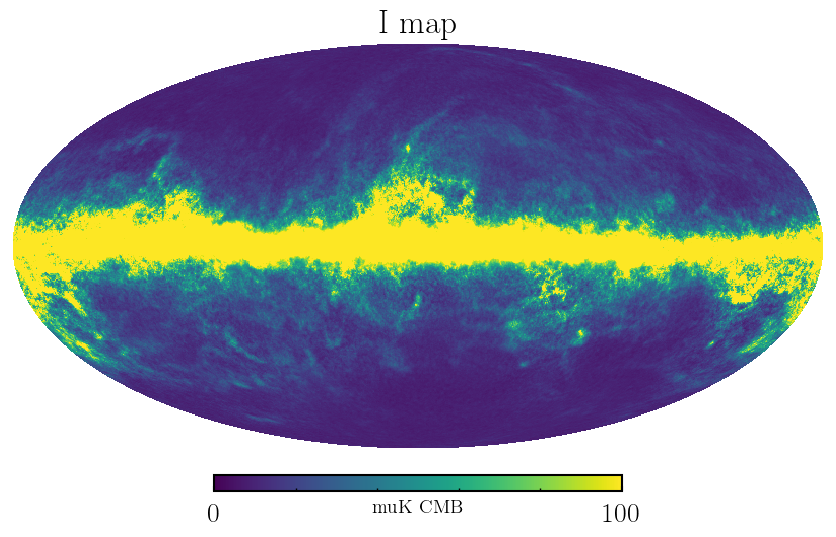

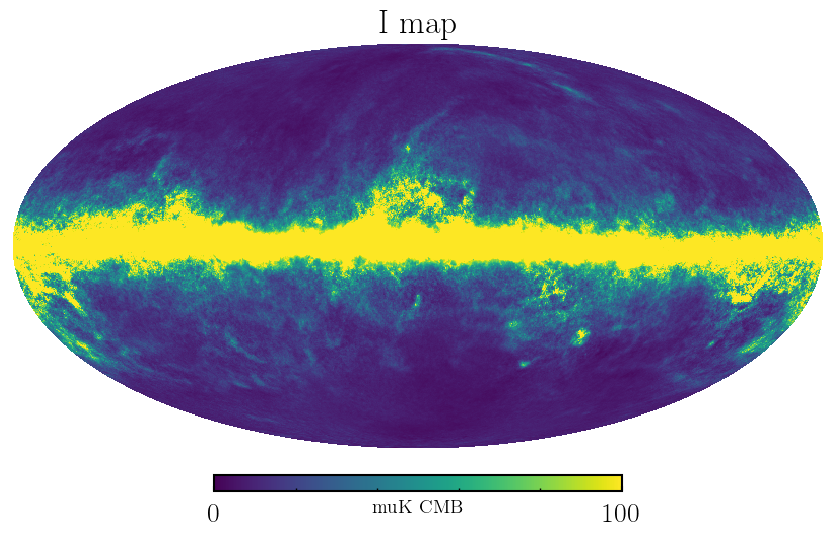

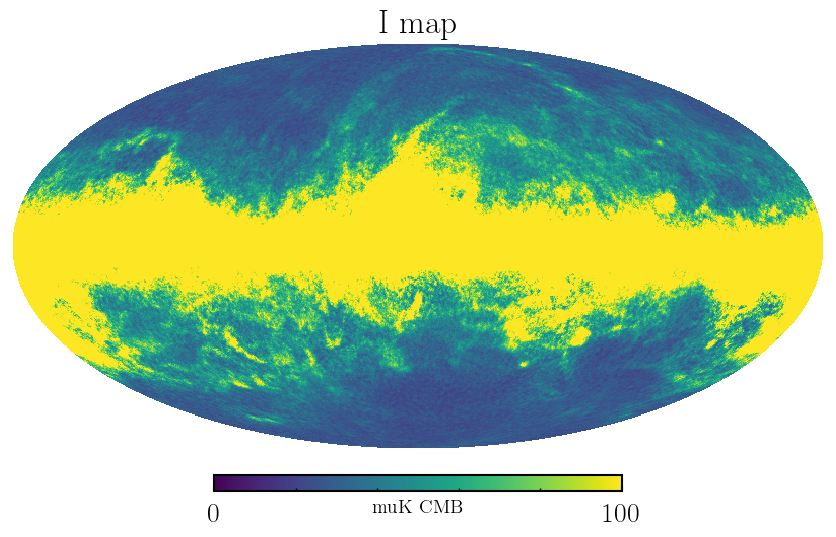

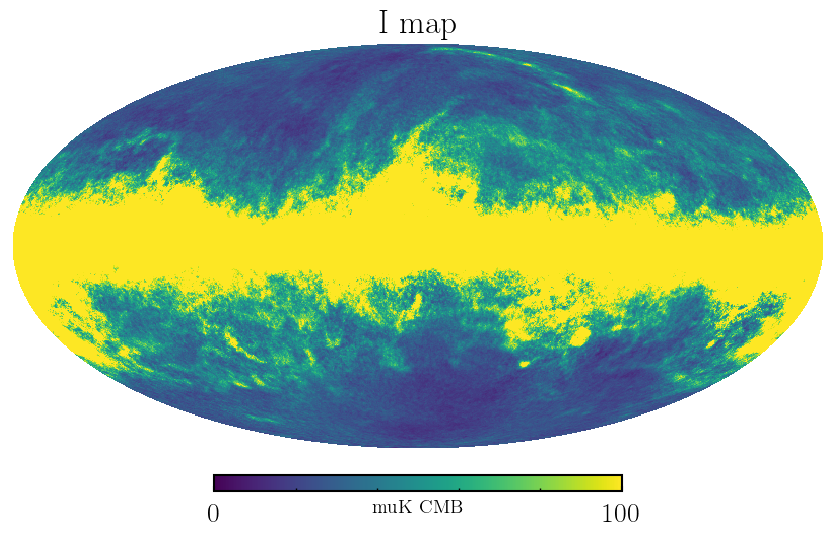

In [5]:
cl_2pts = {}

for freq in [90., 150.]:

    for pysm_model in ['d9', 'd10']:

        print(f"Freq: {freq} PySM: {pysm_model}")
        sky = pysm3.Sky(nside=NSIDE, preset_strings=[pysm_model])
        map_freqGHz = sky.get_emission(freq * u.GHz)
        map_freqGHz = map_freqGHz.to(u.uK_CMB, equivalencies=u.cmb_equivalencies(freq*u.GHz))[0] #  T
        hp.mollview(map_freqGHz, min=0, max=1e2, title="I map", unit='muK CMB')

        for mask in [0, 1, 2, 3]:

            print(f'Mask: {mask}')
            map_measureT = map_freqGHz * masks[mask]

            # Convert the map to alms and compute the power spectrum
            dust_cl = hp.anafast(map_measureT, lmax=mlmax)
            dust_cl /= w2_masks[mask]

            cl_2pts[f'{freq}_{pysm_model}_{dict_mask[mask]}'] = dust_cl

In [8]:
# Guardar amplitudes en un archivo usando pickle
with open('cl_2pts_d9_d10_maps.pkl', 'wb') as file:
    pickle.dump(cl_2pts, file)

In [9]:
# Generar colores discretos
num_colors = 4  # Número total de combinaciones de freq, pysm_model y mask
discrete_colors = get_discrete_colors('viridis', num_colors)

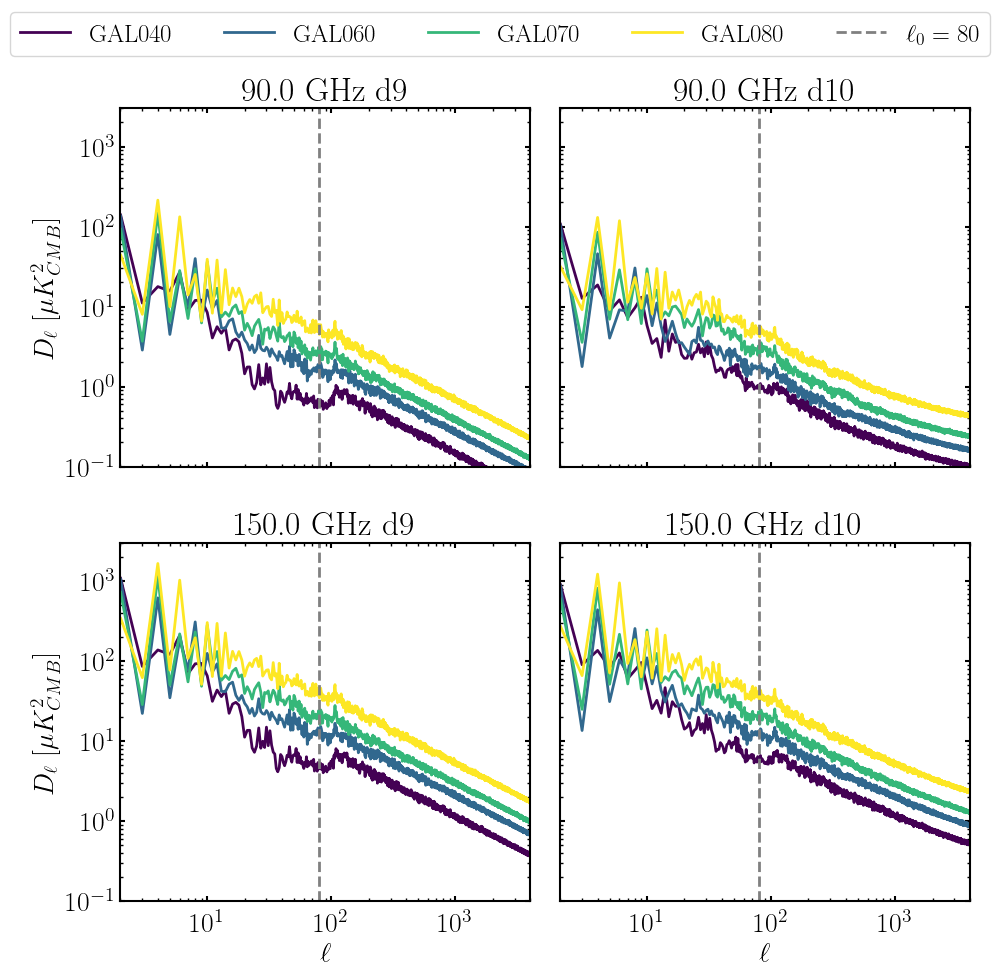

In [28]:
%matplotlib inline
ell = np.arange(mlmax+1)
lfac = ell * (ell + 1) / (2 * np.pi)

fig, ax = plt.subplots(2, 2, figsize=(10,10), sharex=True, sharey=True)

for i, freq in enumerate([90., 150.]):
    for j, pysm_model in enumerate(['d9', 'd10']):
        for mask in [0, 1, 2, 3]:
            ax[i, j].plot(ell, lfac * cl_2pts[f'{freq}_{pysm_model}_{dict_mask[mask]}'], label=f'{dict_mask[mask]}', lw=2, color=discrete_colors[mask])
            
        ax[i, j].axvline(80, color='gray', linestyle='dashed', lw=2, label=r'$\ell_0 = 80$')
        ax[i, j].set_title(f'{freq} GHz {pysm_model}')
        ax[i, j].set_yscale('log')
        ax[i, j].set_xscale('log')
        ax[i, j].set_ylim(0.1, 3e3)
        ax[i, j].set_xlim(2, mlmax)

           
for i in range(2):
     ax[1,i].set_xlabel(r'$\ell$')
     ax[i, 0].set_ylabel(r'$D_{\ell}~[\mu K_{{CMB}}^2]$')

# Colocar la leyenda debajo de todos los subplots
handles, labels = ax[0,0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', ncol=5, prop={'size': 18})

plt.tight_layout(rect=[0, 0, 1, 0.95])  # Ajustar el layout para hacer espacio para la leyenda

fig.savefig('./Figures/cl_2pts_pysm_d9_d10_95-150GHz.png', dpi=300)
plt.show()

/home/ia404/.conda/envs/dr6plus_ice1/lib/python3.8/site-packages/scipy/optimize/_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/tmp/ipykernel_2385899/3017334841.py:34: RuntimeWarning: divide by zero encountered in divide
  dust_cl_generate = dust_dl_generate / (ell * (ell + 1)) * (2 * np.pi)


Amplitud: 21.813211713620227


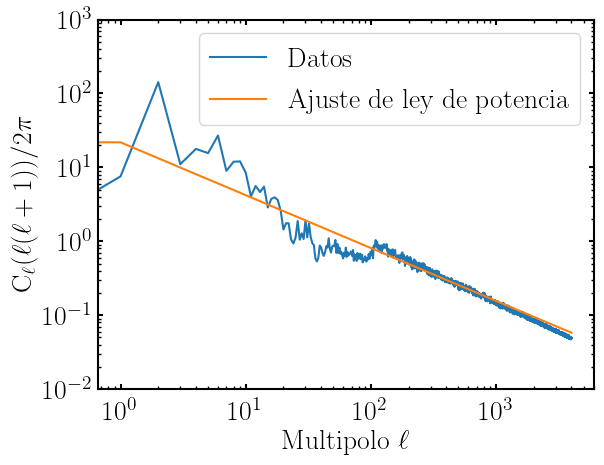

/home/ia404/.conda/envs/dr6plus_ice1/lib/python3.8/site-packages/scipy/optimize/_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/tmp/ipykernel_2385899/3017334841.py:34: RuntimeWarning: divide by zero encountered in divide
  dust_cl_generate = dust_dl_generate / (ell * (ell + 1)) * (2 * np.pi)


Amplitud: 55.29821289960211


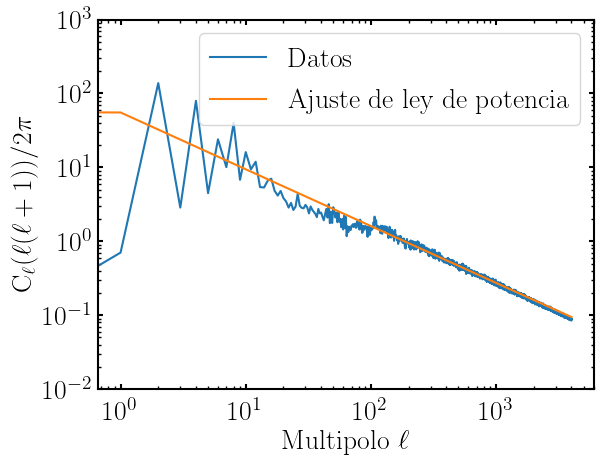

/home/ia404/.conda/envs/dr6plus_ice1/lib/python3.8/site-packages/scipy/optimize/_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/tmp/ipykernel_2385899/3017334841.py:4: RuntimeWarning: invalid value encountered in power
  return amplitude * (x+0.001/L0)**TILT


Amplitud: 103.09023978200881


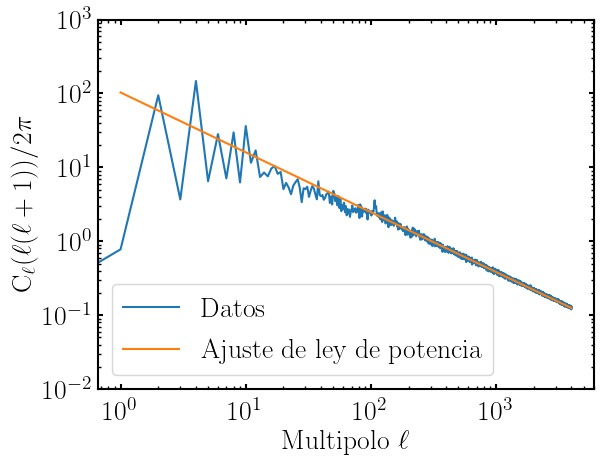

/home/ia404/.conda/envs/dr6plus_ice1/lib/python3.8/site-packages/scipy/optimize/_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/tmp/ipykernel_2385899/3017334841.py:4: RuntimeWarning: invalid value encountered in power
  return amplitude * (x+0.001/L0)**TILT


Amplitud: 193.61304116716593


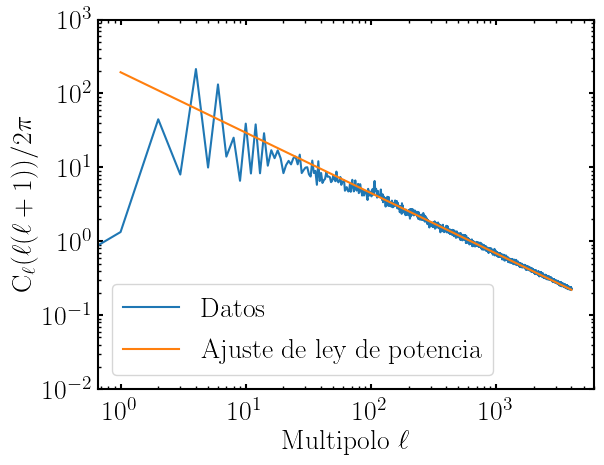

/home/ia404/.conda/envs/dr6plus_ice1/lib/python3.8/site-packages/scipy/optimize/_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/tmp/ipykernel_2385899/3017334841.py:34: RuntimeWarning: divide by zero encountered in divide
  dust_cl_generate = dust_dl_generate / (ell * (ell + 1)) * (2 * np.pi)


Amplitud: 23.823904713935242


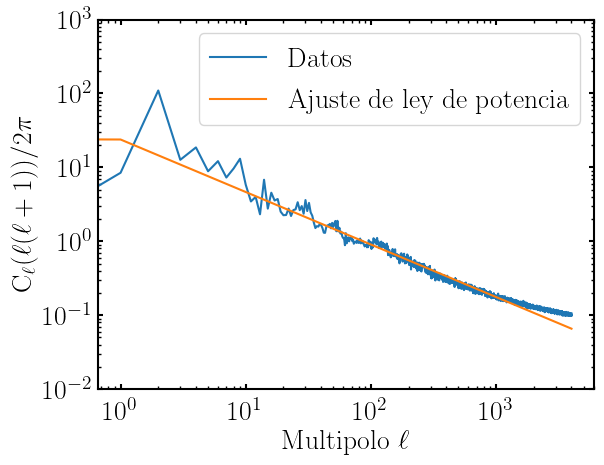

/home/ia404/.conda/envs/dr6plus_ice1/lib/python3.8/site-packages/scipy/optimize/_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/tmp/ipykernel_2385899/3017334841.py:34: RuntimeWarning: divide by zero encountered in divide
  dust_cl_generate = dust_dl_generate / (ell * (ell + 1)) * (2 * np.pi)


Amplitud: 34.40313155271566


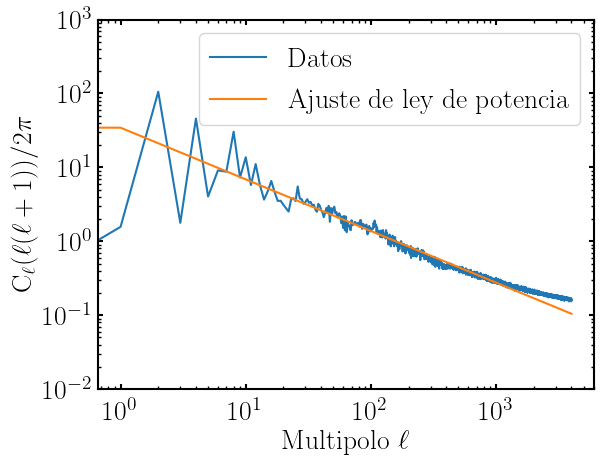

/home/ia404/.conda/envs/dr6plus_ice1/lib/python3.8/site-packages/scipy/optimize/_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/tmp/ipykernel_2385899/3017334841.py:34: RuntimeWarning: divide by zero encountered in divide
  dust_cl_generate = dust_dl_generate / (ell * (ell + 1)) * (2 * np.pi)


Amplitud: 82.11392524598558


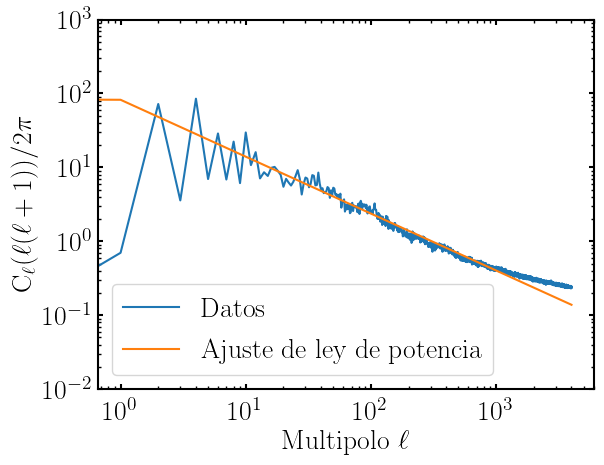

/home/ia404/.conda/envs/dr6plus_ice1/lib/python3.8/site-packages/scipy/optimize/_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/tmp/ipykernel_2385899/3017334841.py:4: RuntimeWarning: invalid value encountered in power
  return amplitude * (x+0.001/L0)**TILT


Amplitud: 106.85726195732205


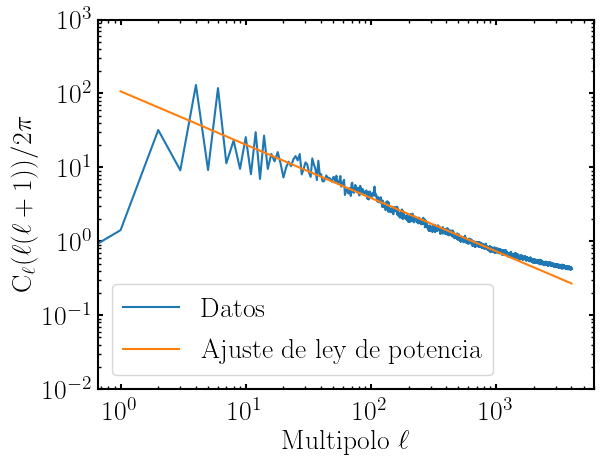

/home/ia404/.conda/envs/dr6plus_ice1/lib/python3.8/site-packages/scipy/optimize/_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/tmp/ipykernel_2385899/3017334841.py:4: RuntimeWarning: invalid value encountered in power
  return amplitude * (x+0.001/L0)**TILT


Amplitud: 169.367365335595


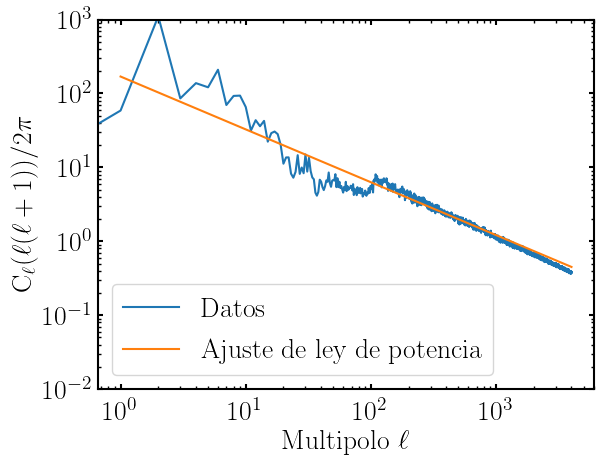

/home/ia404/.conda/envs/dr6plus_ice1/lib/python3.8/site-packages/scipy/optimize/_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/tmp/ipykernel_2385899/3017334841.py:4: RuntimeWarning: invalid value encountered in power
  return amplitude * (x+0.001/L0)**TILT


Amplitud: 429.3606486710763


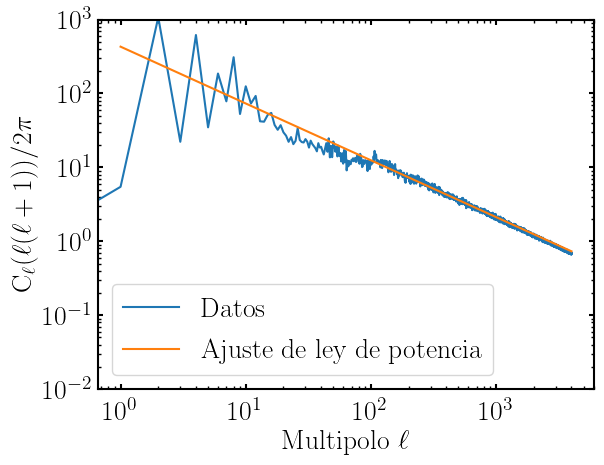

/home/ia404/.conda/envs/dr6plus_ice1/lib/python3.8/site-packages/scipy/optimize/_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/tmp/ipykernel_2385899/3017334841.py:4: RuntimeWarning: invalid value encountered in power
  return amplitude * (x+0.001/L0)**TILT


Amplitud: 800.4397952895717


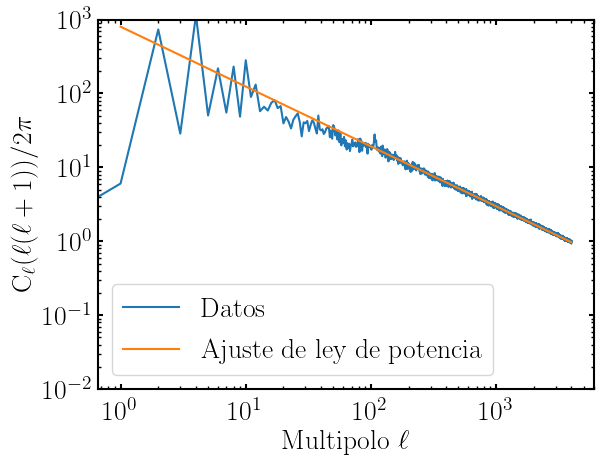

/home/ia404/.conda/envs/dr6plus_ice1/lib/python3.8/site-packages/scipy/optimize/_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/tmp/ipykernel_2385899/3017334841.py:34: RuntimeWarning: divide by zero encountered in divide
  dust_cl_generate = dust_dl_generate / (ell * (ell + 1)) * (2 * np.pi)


Amplitud: 1503.3002384667159


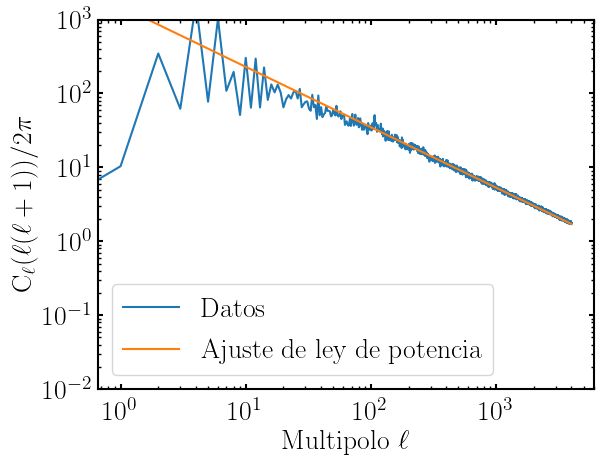

/home/ia404/.conda/envs/dr6plus_ice1/lib/python3.8/site-packages/scipy/optimize/_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/tmp/ipykernel_2385899/3017334841.py:4: RuntimeWarning: invalid value encountered in power
  return amplitude * (x+0.001/L0)**TILT


Amplitud: 171.77200581980364


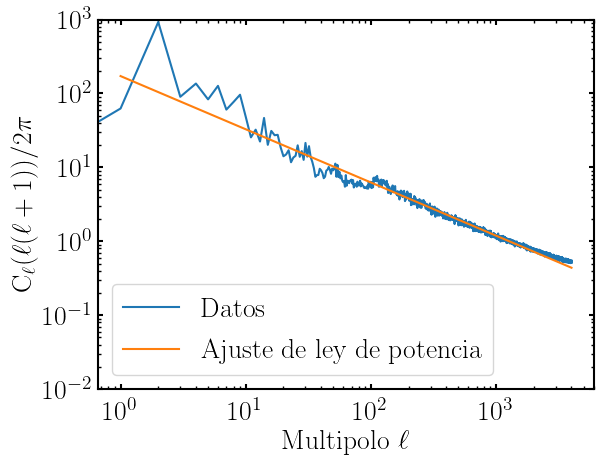

/home/ia404/.conda/envs/dr6plus_ice1/lib/python3.8/site-packages/scipy/optimize/_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/tmp/ipykernel_2385899/3017334841.py:4: RuntimeWarning: invalid value encountered in power
  return amplitude * (x+0.001/L0)**TILT


Amplitud: 334.78191680577464


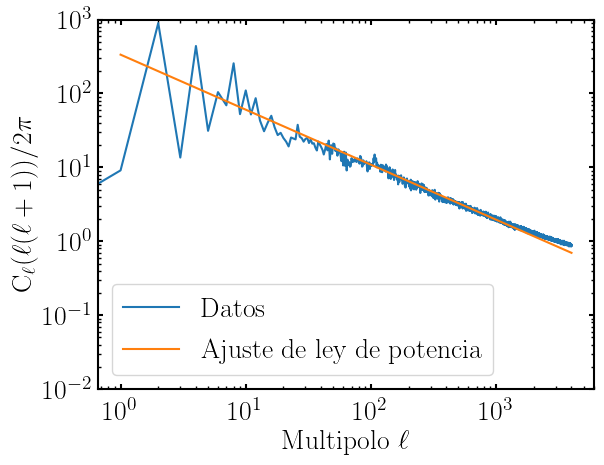

/home/ia404/.conda/envs/dr6plus_ice1/lib/python3.8/site-packages/scipy/optimize/_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/tmp/ipykernel_2385899/3017334841.py:4: RuntimeWarning: invalid value encountered in power
  return amplitude * (x+0.001/L0)**TILT


Amplitud: 721.0789306861817


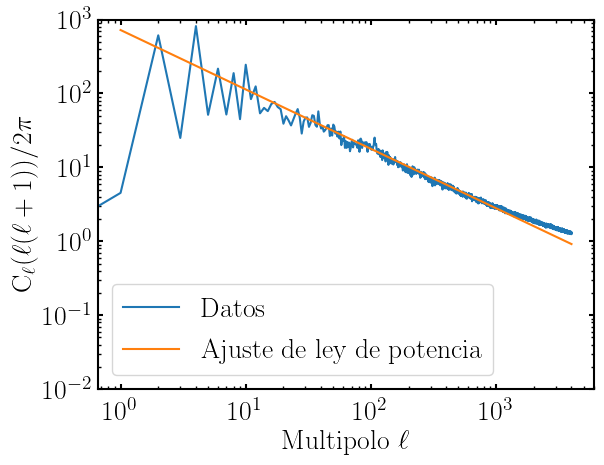

/home/ia404/.conda/envs/dr6plus_ice1/lib/python3.8/site-packages/scipy/optimize/_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/tmp/ipykernel_2385899/3017334841.py:34: RuntimeWarning: divide by zero encountered in divide
  dust_cl_generate = dust_dl_generate / (ell * (ell + 1)) * (2 * np.pi)


Amplitud: 1143.3228691471031


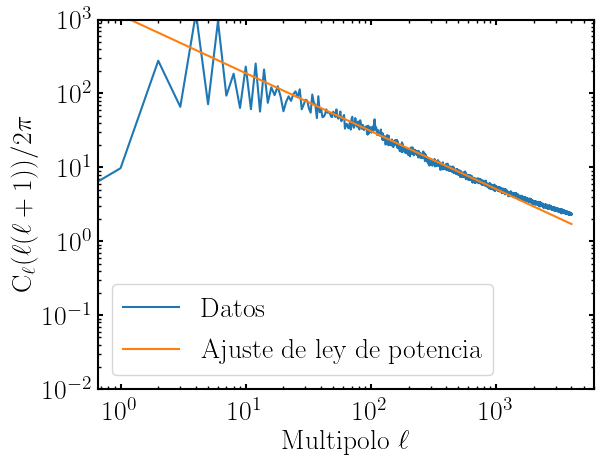

In [16]:

# Definir la función de ley de potencia
def power_law(x, amplitude, TILT = -0.80, L0=80):

    return amplitude * (x+0.001/L0)**TILT

# Definir el rango de ell para el ajuste
ell_min = 80 #100 # l1 pysm
ell_max = 2000 # l2 pysm

# Filtrar los datos para el rango seleccionado
ell_range = (ell >= ell_min) & (ell <= ell_max)
ell_fit = ell[ell_range]

amplitudes = {}

for freq in [90., 150.]:
    for pysm_model in ['d9', 'd10']:
        for mask in [0, 1, 2, 3]:

            dust_fit = lfac * cl_2pts[f'{freq}_{pysm_model}_{dict_mask[mask]}']
            dust_cl_fit = dust_fit[ell_range]

            # Ajustar la función de ley de potencia a los datos
            popt, pcov = curve_fit(power_law, ell_fit, dust_cl_fit)

            # Obtener los parámetros ajustados
            amplitudes[f'{freq}_{pysm_model}_{dict_mask[mask]}'] = popt[0] # , tilt

            # Imprimir los parámetros ajustados
            print(f"Amplitud: {popt[0]}")
            # print(f"Inclinación: {tilt}")

            dust_dl_generate = power_law(ell, *popt)
            dust_cl_generate = dust_dl_generate / (ell * (ell + 1)) * (2 * np.pi)
            dust_cl_generate[0] = 0 
            # Graficar los datos originales y la curva ajustada
            plt.figure()
            plt.plot(ell, dust_fit, label='Datos')
            plt.plot(ell, dust_dl_generate, label='Ajuste de ley de potencia')
            plt.xlabel('Multipolo $\ell$')
            plt.ylabel('C$_\ell (\ell ( \ell+1)) / 2\pi$')
            plt.xscale('log')
            plt.yscale('log')
            plt.ylim(1e-2, 1e3)
            plt.legend()
            plt.show()

In [17]:
amplitudes

{'90.0_d9_GAL040': 21.813211713620227,
 '90.0_d9_GAL060': 55.29821289960211,
 '90.0_d9_GAL070': 103.09023978200881,
 '90.0_d9_GAL080': 193.61304116716593,
 '90.0_d10_GAL040': 23.823904713935242,
 '90.0_d10_GAL060': 34.40313155271566,
 '90.0_d10_GAL070': 82.11392524598558,
 '90.0_d10_GAL080': 106.85726195732205,
 '150.0_d9_GAL040': 169.367365335595,
 '150.0_d9_GAL060': 429.3606486710763,
 '150.0_d9_GAL070': 800.4397952895717,
 '150.0_d9_GAL080': 1503.3002384667159,
 '150.0_d10_GAL040': 171.77200581980364,
 '150.0_d10_GAL060': 334.78191680577464,
 '150.0_d10_GAL070': 721.0789306861817,
 '150.0_d10_GAL080': 1143.3228691471031}

In [18]:
# Guardar amplitudes en un archivo usando pickle
with open('amplitudes.pkl', 'wb') as file:
    pickle.dump(amplitudes, file)

In [19]:
with open('amplitudes.pkl', 'rb') as file:
    saveamplitudes = pickle.load(file)

In [20]:
saveamplitudes

{'90.0_d9_GAL040': 21.813211713620227,
 '90.0_d9_GAL060': 55.29821289960211,
 '90.0_d9_GAL070': 103.09023978200881,
 '90.0_d9_GAL080': 193.61304116716593,
 '90.0_d10_GAL040': 23.823904713935242,
 '90.0_d10_GAL060': 34.40313155271566,
 '90.0_d10_GAL070': 82.11392524598558,
 '90.0_d10_GAL080': 106.85726195732205,
 '150.0_d9_GAL040': 169.367365335595,
 '150.0_d9_GAL060': 429.3606486710763,
 '150.0_d9_GAL070': 800.4397952895717,
 '150.0_d9_GAL080': 1503.3002384667159,
 '150.0_d10_GAL040': 171.77200581980364,
 '150.0_d10_GAL060': 334.78191680577464,
 '150.0_d10_GAL070': 721.0789306861817,
 '150.0_d10_GAL080': 1143.3228691471031}

In [ ]:
# yay